<a href="https://colab.research.google.com/github/k2345810/k2345810--Project-Dessertation/blob/main/GRU_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libraries
!pip install dask[complete]
!pip install imbalanced-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.1 MB/s eta 0:00:00


In [2]:
#Connecting to Google Drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
# Parallel Processing: Dask reads data in parallel, breaking it into smaller, manageable chunks, and then processes these
# chunks concurrently. This makes it possible to handle large datasets that
# don’t fit into memory.
import dask.dataframe as dd
file_path = '/content/drive/My Drive/CICIDS2018.csv'
ddf = dd.read_csv(file_path)

# Converting to Pandas DataFrame for processing
df = ddf.compute()

# Using 30% of the dataset
df = df.sample(frac=0.3, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
#feature reduction
# Encode the Label column
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Number of features before selection
print(f"Total features before selection: {df.shape[1] - 1}")

# Subsampling the data to make the calculation faster
sample_size = 200000
df_sample = df.sample(n=sample_size, random_state=42)

# Separate features and target for the subsample
X_sample = df_sample.drop('Label', axis=1)
y_sample = df_sample['Label']

# Train a RandomForest to get feature importances
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_sample, y_sample)
feature_importances = pd.Series(clf.feature_importances_, index=X_sample.columns)

# Sort features by importance
feature_importances = feature_importances.sort_values(ascending=False)
print("Feature importances from subsample:")
print(feature_importances)

# Select features with importance greater than a threshold
threshold = 0.01
selected_features = feature_importances[feature_importances > threshold].index
print(f"Selected Features: {selected_features}")

# Reduce full dataset to the selected features
df_reduced = df[selected_features.to_list() + ['Label']]

# Print total number of features after selection
print(f"Total features after selection: {df_reduced.shape[1] - 1}")  #exculding label columns

# Separate features and target for full dataset
X = df_reduced.drop('Label', axis=1)
y = df_reduced['Label']


Total features before selection: 78
Feature importances from subsample:
Init Fwd Win Byts    0.095170
Dst Port             0.081770
Fwd Seg Size Min     0.064813
Fwd Header Len       0.038531
Flow Pkts/s          0.038458
                       ...   
Fwd Byts/b Avg       0.000000
Bwd Byts/b Avg       0.000000
Fwd Blk Rate Avg     0.000000
Bwd Pkts/b Avg       0.000000
Bwd Blk Rate Avg     0.000000
Length: 78, dtype: float64
Selected Features: Index(['Init Fwd Win Byts', 'Dst Port', 'Fwd Seg Size Min', 'Fwd Header Len',
       'Flow Pkts/s', 'Flow IAT Min', 'Flow Duration', 'Flow IAT Max',
       'TotLen Fwd Pkts', 'Fwd IAT Mean', 'Fwd Pkts/s', 'Flow IAT Mean',
       'Fwd IAT Tot', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkt Len Mean',
       'Fwd Seg Size Avg', 'Fwd Pkt Len Max', 'Subflow Fwd Byts', 'Bwd Pkts/s',
       'Init Bwd Win Byts', 'Subflow Fwd Pkts', 'Flow IAT Std', 'Flow Byts/s',
       'Pkt Len Max', 'Bwd Pkt Len Std', 'Bwd Pkt Len Mean'],
      dtype='object')
Total features 

In [5]:
# skiped as no missing values found
#threshold = len(df_reduced) * 0.5
#df_reduced = df_reduced.dropna(thresh=threshold, axis=1)
#df_reduced = df_reduced.fillna(df_reduced.median())

# Separated features and target after handling missing values
X = df_reduced.drop('Label', axis=1)
y = df_reduced['Label']

In [6]:
# Normalize/Standardize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Original number of features: 27
Reduced number of features after PCA: 11
Class distribution before handling imbalance:
Label
0     1338539
4       69002
6       57624
8       46247
1       28589
11      19494
14      18915
12      15965
9       13800
7        4152
10       1121
5         194
2          50
3          17
13          9
Name: count, dtype: int64
Class distribution after handling imbalance:
Label
0     1338539
11    1338539
7     1338539
4     1338539
8     1338539
6     1338539
14    1338539
1     1338539
9     1338539
12    1338539
5     1338539
10    1338539
3     1338539
2     1338539
13    1338539
Name: count, dtype: int64


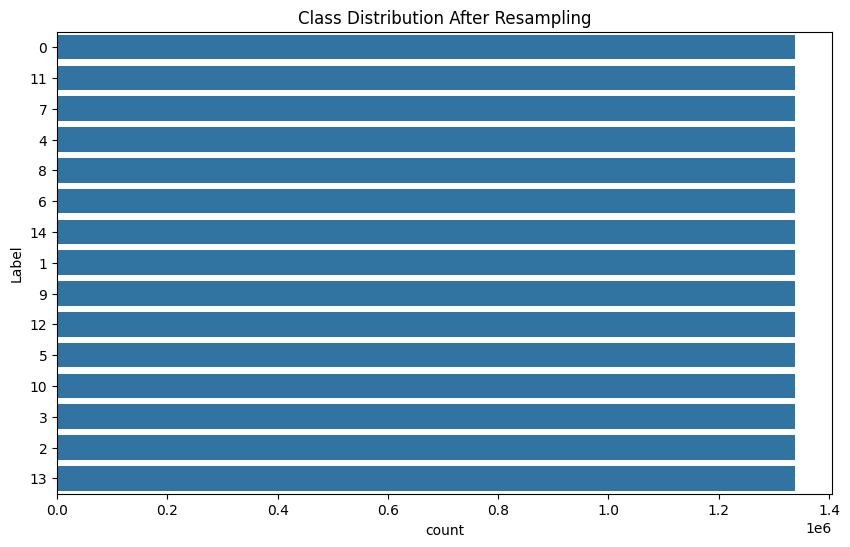

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

# Before handling class imbalance
print("Class distribution before handling imbalance:")
print(y.value_counts())

# Handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# After handling class imbalance
print("Class distribution after handling imbalance:")
print(pd.Series(y_resampled).value_counts())

# Visualize class distribution after resampling
plt.figure(figsize=(10, 6))
sns.countplot(y=y_resampled, order=pd.Series(y_resampled).value_counts().index)
plt.title('Class Distribution After Resampling')
plt.show()


##GRU Model

Epoch 1/10
209139/209147 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.8772
Epoch 1: val_loss improved from inf to 0.19276, saving model to best_gru_model_fold1.keras
209147/209147 [==============================] - 1340s 6ms/step - loss: 0.2214 - accuracy: 0.8772 - val_loss: 0.1928 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 2/10
209140/209147 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.8860
Epoch 2: val_loss improved from 0.19276 to 0.18569, saving model to best_gru_model_fold1.keras
209147/209147 [==============================] - 1318s 6ms/step - loss: 0.1997 - accuracy: 0.8860 - val_loss: 0.1857 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 3/10
209139/209147 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.8880
Epoch 3: val_loss improved from 0.18569 to 0.18254, saving model to best_gru_model_fold1.keras
209147/209147 [==============================] - 1310s 6ms/step - loss: 0.1949 - accuracy: 0.8880 - val_los

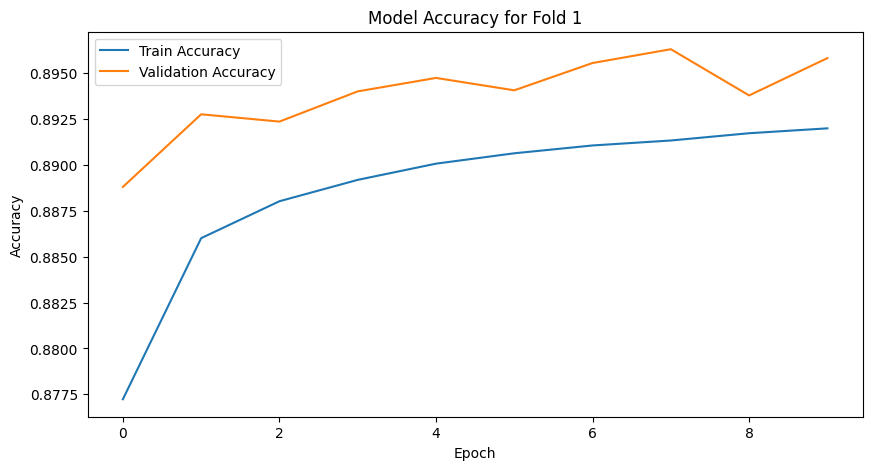

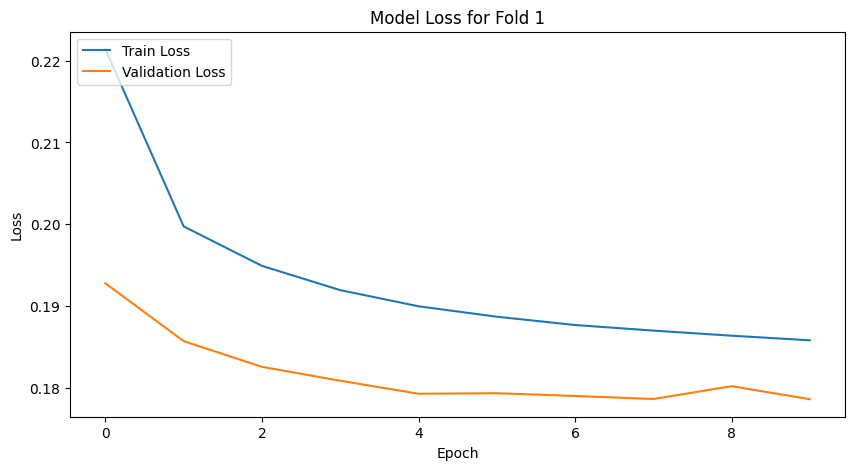

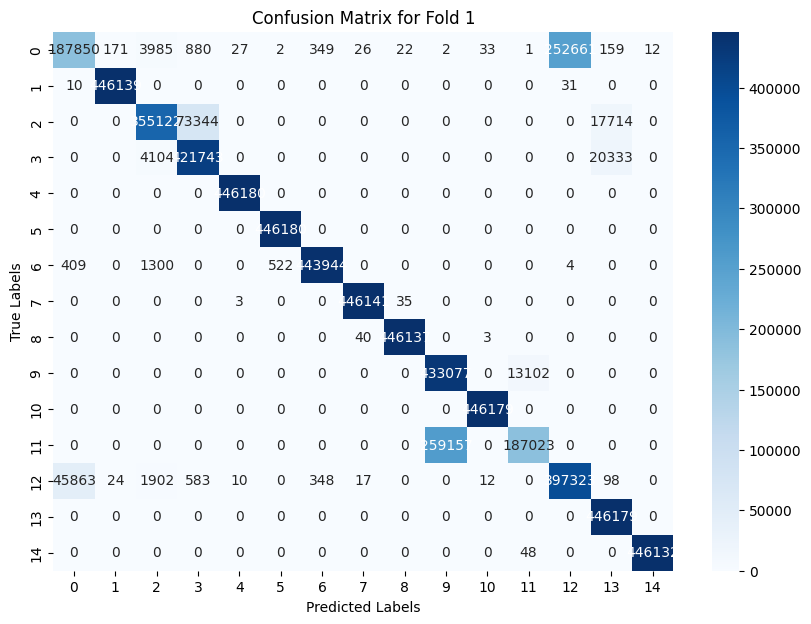

Epoch 1/10
209138/209147 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.8775
Epoch 1: val_loss improved from inf to 0.19134, saving model to best_gru_model_fold2.keras
209147/209147 [==============================] - 1347s 6ms/step - loss: 0.2211 - accuracy: 0.8775 - val_loss: 0.1913 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 2/10
209145/209147 [============================>.] - ETA: 0s - loss: 0.1998 - accuracy: 0.8861
Epoch 2: val_loss improved from 0.19134 to 0.18727, saving model to best_gru_model_fold2.keras
209147/209147 [==============================] - 1340s 6ms/step - loss: 0.1998 - accuracy: 0.8861 - val_loss: 0.1873 - val_accuracy: 0.8916 - lr: 0.0010
Epoch 3/10
209143/209147 [============================>.] - ETA: 0s - loss: 0.1950 - accuracy: 0.8882
Epoch 3: val_loss did not improve from 0.18727
209147/209147 [==============================] - 1352s 6ms/step - loss: 0.1950 - accuracy: 0.8882 - val_loss: 0.1890 - val_accuracy: 0.8912 - lr: 0.0010
Ep

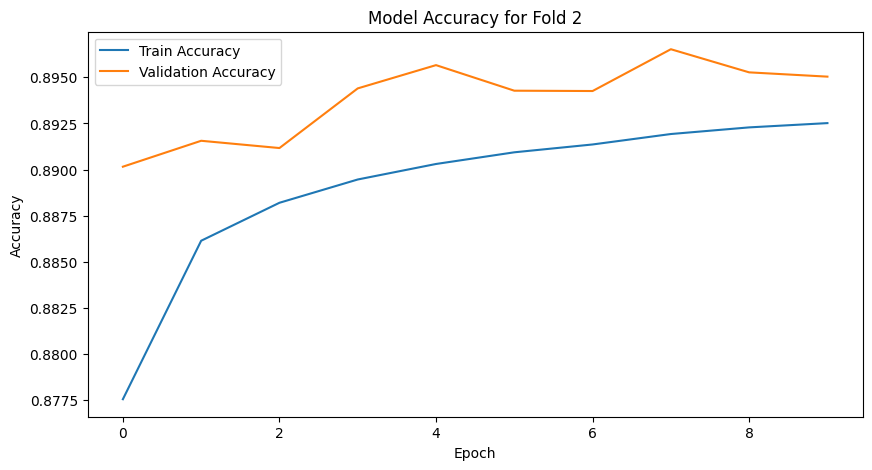

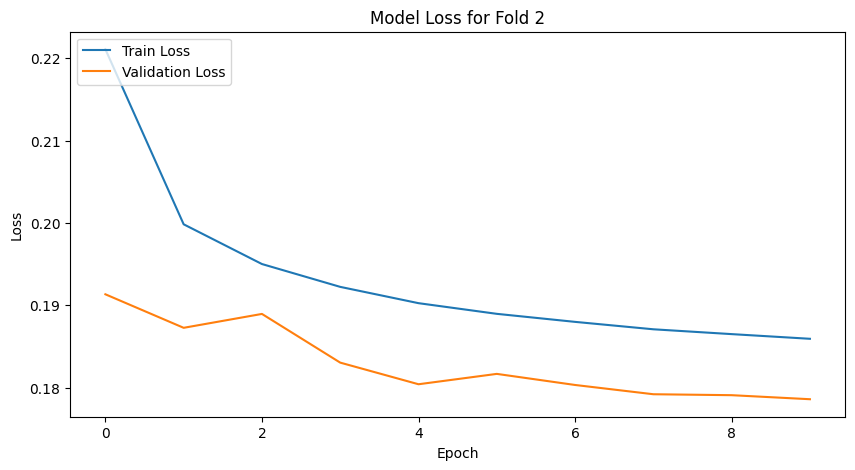

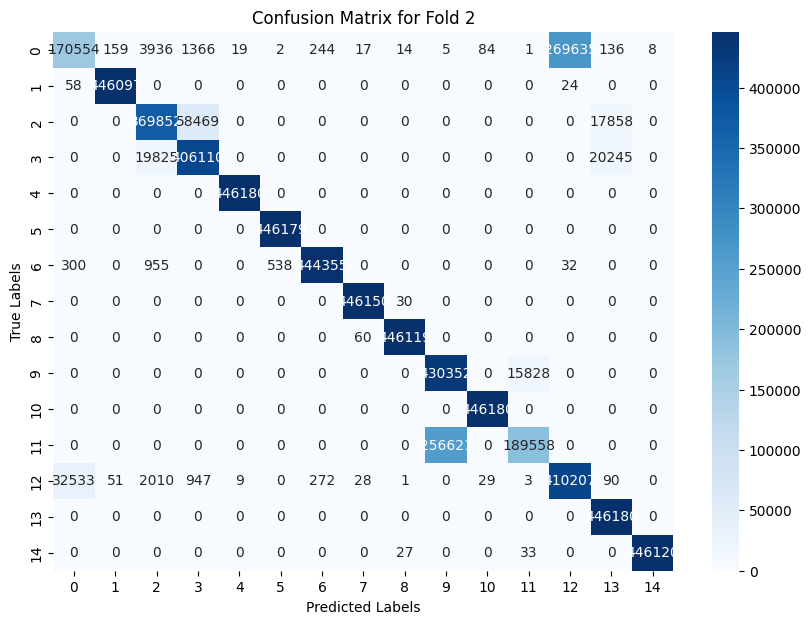

Epoch 1/10
209139/209147 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.8772
Epoch 1: val_loss improved from inf to 0.19059, saving model to best_gru_model_fold3.keras
209147/209147 [==============================] - 1369s 7ms/step - loss: 0.2221 - accuracy: 0.8772 - val_loss: 0.1906 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 2/10
209142/209147 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.8858
Epoch 2: val_loss improved from 0.19059 to 0.18596, saving model to best_gru_model_fold3.keras
209147/209147 [==============================] - 1349s 6ms/step - loss: 0.2006 - accuracy: 0.8858 - val_loss: 0.1860 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 3/10
209144/209147 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.8880
Epoch 3: val_loss improved from 0.18596 to 0.18310, saving model to best_gru_model_fold3.keras
209147/209147 [==============================] - 1346s 6ms/step - loss: 0.1954 - accuracy: 0.8880 - val_los

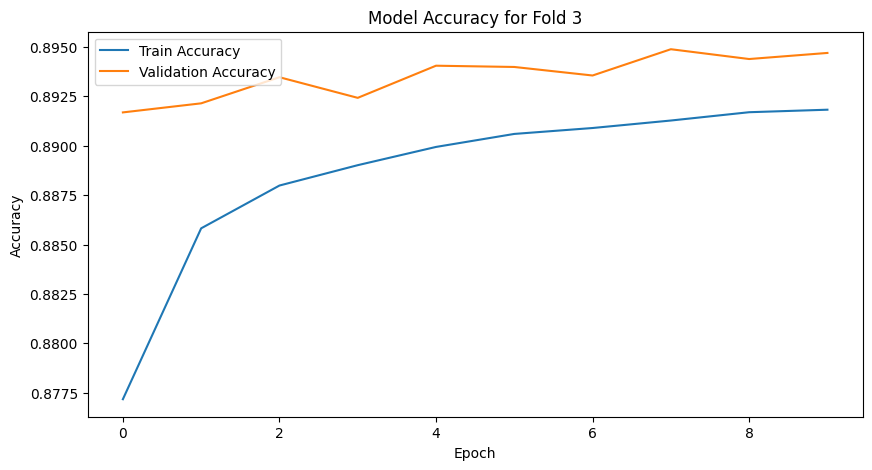

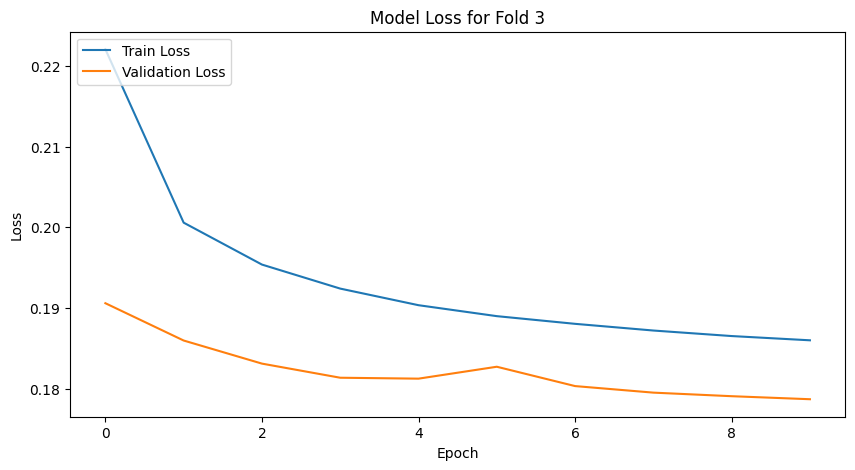

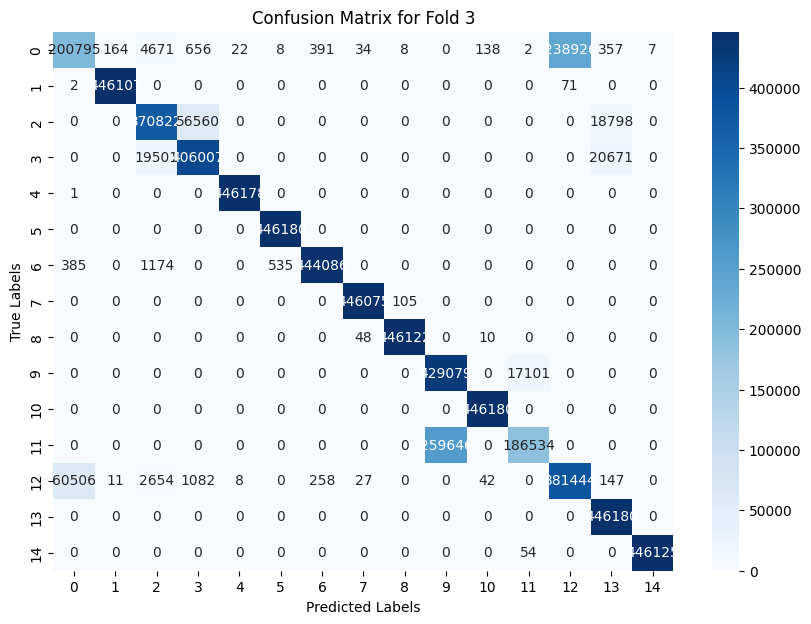

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.1785803735256195 - Accuracy: 89.58048820495605% - Precision: 0.9139500486669844 - Recall: 0.8958049037047109 - F1 Score: 0.8893172909337423 - ROC-AUC: 0.9441811992569602
------------------------------------------------------------------------
> Fold 2 - Loss: 0.17860941588878632 - Accuracy: 89.50344920158386% - Precision: 0.9140414658823798 - Recall: 0.8950345115084432 - F1 Score: 0.8878010991347325 - ROC-AUC: 0.9437684858637139
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1786898821592331 - Accuracy: 89.46939706802368% - Precision: 0.9092540833578221 - Recall: 0.8946939909856941 - F1 Score: 0.88898149613971 - ROC-AUC: 0.9435860681794673
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 89.52% (+- 0

In [8]:
#GRU Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Reshape data for GRU: (samples, timesteps, features)
X_scaled_gru = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize K-fold cross-validation
num_folds = 3
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Prepare storage for the fold results
fold_no = 1
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
roc_auc_per_fold = []
conf_matrices = []

for train, test in kfold.split(X_scaled_gru, y_resampled):
    # GRU model architecture
    model = Sequential(name="GRU_Model_with_KFold_Validation")
    model.add(GRU(128, return_sequences=True, input_shape=(X_scaled_gru.shape[1], X_scaled_gru.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(GRU(64))
    model.add(Dropout(0.3))
    model.add(Dense(len(np.unique(y_resampled)), activation='softmax'))

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_gru_model_fold{fold_no}.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

    # Fit data to model
    history = model.fit(X_scaled_gru[train], y_resampled[train],
                        batch_size=64,
                        epochs=10,
                        verbose=1,
                        validation_data=(X_scaled_gru[test], y_resampled[test]),
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Evaluate
    scores = model.evaluate(X_scaled_gru[test], y_resampled[test], verbose=0)
    print(f'Score for fold {fold_no}: Accuracy of {scores[1]*100:.2f}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predictions and metrics
    y_pred = np.argmax(model.predict(X_scaled_gru[test]), axis=1)
    precision = precision_score(y_resampled[test], y_pred, average='weighted')
    recall = recall_score(y_resampled[test], y_pred, average='weighted')
    f1 = f1_score(y_resampled[test], y_pred, average='weighted')
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_resampled[test]), tf.keras.utils.to_categorical(y_pred), average='weighted')

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_score_per_fold.append(f1)
    roc_auc_per_fold.append(roc_auc)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_resampled[test], y_pred)
    conf_matrices.append(conf_matrix)

    # Plotting training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for Fold {fold_no}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plotting training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for Fold {fold_no}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Enhanced Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    fold_no += 1

# AVG Scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1 Score: {f1_score_per_fold[i]} - ROC-AUC: {roc_auc_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold):.2f}% (+- {np.std(acc_per_fold):.2f}%)')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Precision: {np.mean(precision_per_fold)}')
print(f'> Recall: {np.mean(recall_per_fold)}')
print(f'> F1 Score: {np.mean(f1_score_per_fold)}')
print(f'> ROC-AUC: {np.mean(roc_auc_per_fold)}')
print('------------------------------------------------------------------------')
